# Abel Sample

In [7]:
from functools import lru_cache
from pathlib import Path

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def A(k: int, n: int):
    return (((n + 1) ** 2 - k ** 2) ** 0.5 - (n ** 2 - k ** 2) ** 0.5) / (2 * n + 1)


def B(k: int, n: int):
    if n == k: return - A(k, k)
    if n >= k + 1: return A(k, n - 1) - A(k, n)
    return 0


@lru_cache(maxsize=10)
def __create_matrix(N: int) -> np.ndarray:
    """
    Get array B for the Abel inversion. See reference paper.
    This function is much slower than function create_matrix, especially when the number of data is large.
    It is not recommended to use this function.

    Args:
        N (int): Number of data for Abel inversion.

    Returns:
        np.ndarray[int]: Array B for the Abel inversion. See reference paper.
    """
    k, n = np.meshgrid(np.arange(N), np.arange(N))
    return np.array([B(_k, _n) for _n, _k in zip(n.ravel(), k.ravel())]).reshape((N, N))


@lru_cache(maxsize=10)
def create_matrix(N: int) -> np.ndarray:
    """
    Get array B for the Abel inversion. See reference paper.
    Function that executes much faster than the function in __create_matrix.
    It is recommended to use this function.

    Args:
        N (int): Number of data for Abel inversion.

    Returns:
        np.ndarray[int]: Array B for the Abel inversion. See reference paper.
    """
    k, n = np.meshgrid(np.arange(N), np.arange(N))
    B_array = np.zeros_like(k)
    with np.errstate(invalid="ignore"):
        B_array = np.where(n == k, - A(k, k), B_array)
        B_array = np.where(n >= k + 1, A(k, n - 1) - A(k, n), B_array)
    return B_array


def abel_inversion(data: np.ndarray, a: float = 1.0) -> np.ndarray:
    """Perform Abel inversion.
    If the noise amplification is large, it is recommended to smooth or fit the data before inversion.

    Args:
        data (np.ndarray[int|float]): Array to be Abel inversion. For 2D arrays, Abel inversion is performed on each row.
        a (float, optional): the spatial width of the data. Defaults to 1.0.

    Raises:
        ValueError: Error when array is 3 or more dimensional.

    Returns:
        np.ndarray[float]: Array after Abel inversion.
    """

    if data.ndim == 1:
        length = data.shape[0]
    elif data.ndim == 2:
        length = data.shape[1]
    else:
        raise ValueError("Arrays with more than 3 dimensions are not supported")

    inversion_matrix = create_matrix(length)
    return - (2 / np.pi / a) * data @ inversion_matrix

In [11]:
# The functions for Abel inversion was tested with the code below

# test function for radiation coefficient
emission_coefficient = lambda r: np.where(abs(r) < 1, 1 - 2 * r ** 2 + r ** 4, 0)
# test function for integrated radiance
radiance = lambda x: np.where(abs(x) < 1, 16 / 15 * (1 - x ** 2) ** 2.5, 0)

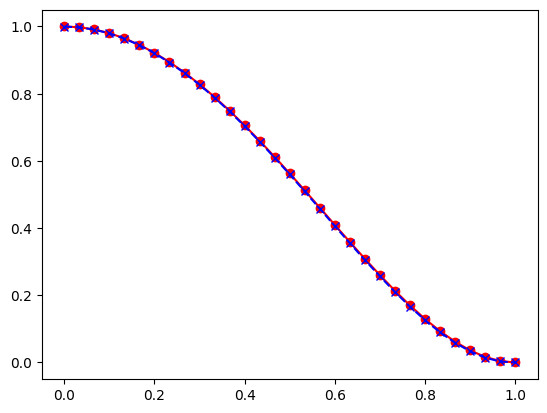

In [15]:
# the number of data
N = 30
# the x-coordinate of the data
x = np.arange(N + 1) / N

# perform inverse abel transform
abel = abel_inversion(radiance(x), 1 / N)

plt.plot(x, emission_coefficient(x), 'o-r', x, abel, 'x--b')
plt.show()

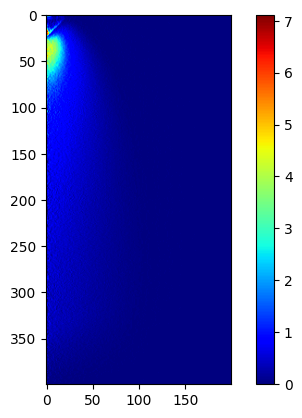

In [25]:
axis = 199
img_file = "Img/Sample_1.tif"

img = np.array(Image.open(img_file), np.int16)

l_img = img[:,axis:]

abel_img = abel_inversion(l_img)

plt.imshow(np.maximum(abel_img, 0), cmap="jet")
plt.colorbar()
plt.show()